In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
import hdbscan
%matplotlib inline
from filter_data import *
from syn_model import *
from load_and_clean import *
from cycler import cycler

import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from scipy.stats import kstest
from sklearn.metrics import mean_squared_error


#IPython.OutputArea.auto_scroll_threshold = 9999;

C:\Users\wangy\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading data

In [3]:
#update_data()
#us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple = load_clean('mobility Apple')
mobility_data_google, google_social = load_clean('mobility Google')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

ctp_us_data = load_clean('CTP US')
ctp_state_data = load_clean('CTP states')
ctp_state_pop_adjusted = {stat: create_population_adjusted_data(data, all_population, show_exception=False) for stat, data in ctp_state_data.items()}

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'West Bank and Gaza', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [4]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)
#deaths_intervention_adjusted_google, deaths_intervention_adjusted_daily_google, _ = create_intervention_adjusted_data(all_data, google_social, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

hospitalized_pop_adjusted, hospitalized_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['hospitalizedCurrently'], educational_distancing, t, ignore_nan=True)
icu_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['inIcuCurrently'], educational_distancing, t, ignore_nan=True)
ventilator_pop_adjusted, icu_pop_adjusted_daily, _ = create_intervention_adjusted_data(ctp_state_pop_adjusted['onVentilatorCurrently'], educational_distancing, t, ignore_nan=True)


last date
Exceptions are []


## Set up possible donors

In [7]:
#collect donors pool which consist the counties in cluster_2_state with long spreading time 
#cluster_2_states = no_bar_no_dining = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii

cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

## Train model with different singular values

In [8]:
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'

df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']

models = []

for singVals in range(1,30):

    target_model = []
    cluster_2_model = []

    #print("Intervention date: ", testDF.index[0])
    for state in targets:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                                                                                         > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
        otherStates = list(otherStates[otherStates.isin(donors)])
        if state in otherStates:
            otherStates.remove(state)


        rscModel = syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel.fit_model()
        target_model.append(rscModel)

        predictions = rscModel.predictions
        model_fit = rscModel.model_fit

        new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]

        if new_state in otherStates:
            otherStates.remove(new_state)

        rscModel2 = syn_model(new_state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
        rscModel2.fit_model()
        cluster_2_model.append(rscModel2)

        predictions = rscModel2.predictions
        model_fit = rscModel2.model_fit
    
    models.append((target_model, cluster_2_model)) #Storing both the model for noreasther state and our target state


In [9]:
models[0][0][0].train.to_csv("testing.csv")

In [196]:
print(len(models), len(models[0]), len(models[0][0]))

29 2 5


## Filter out some counties with high RI

Analysis for state Bartholomew-Indiana


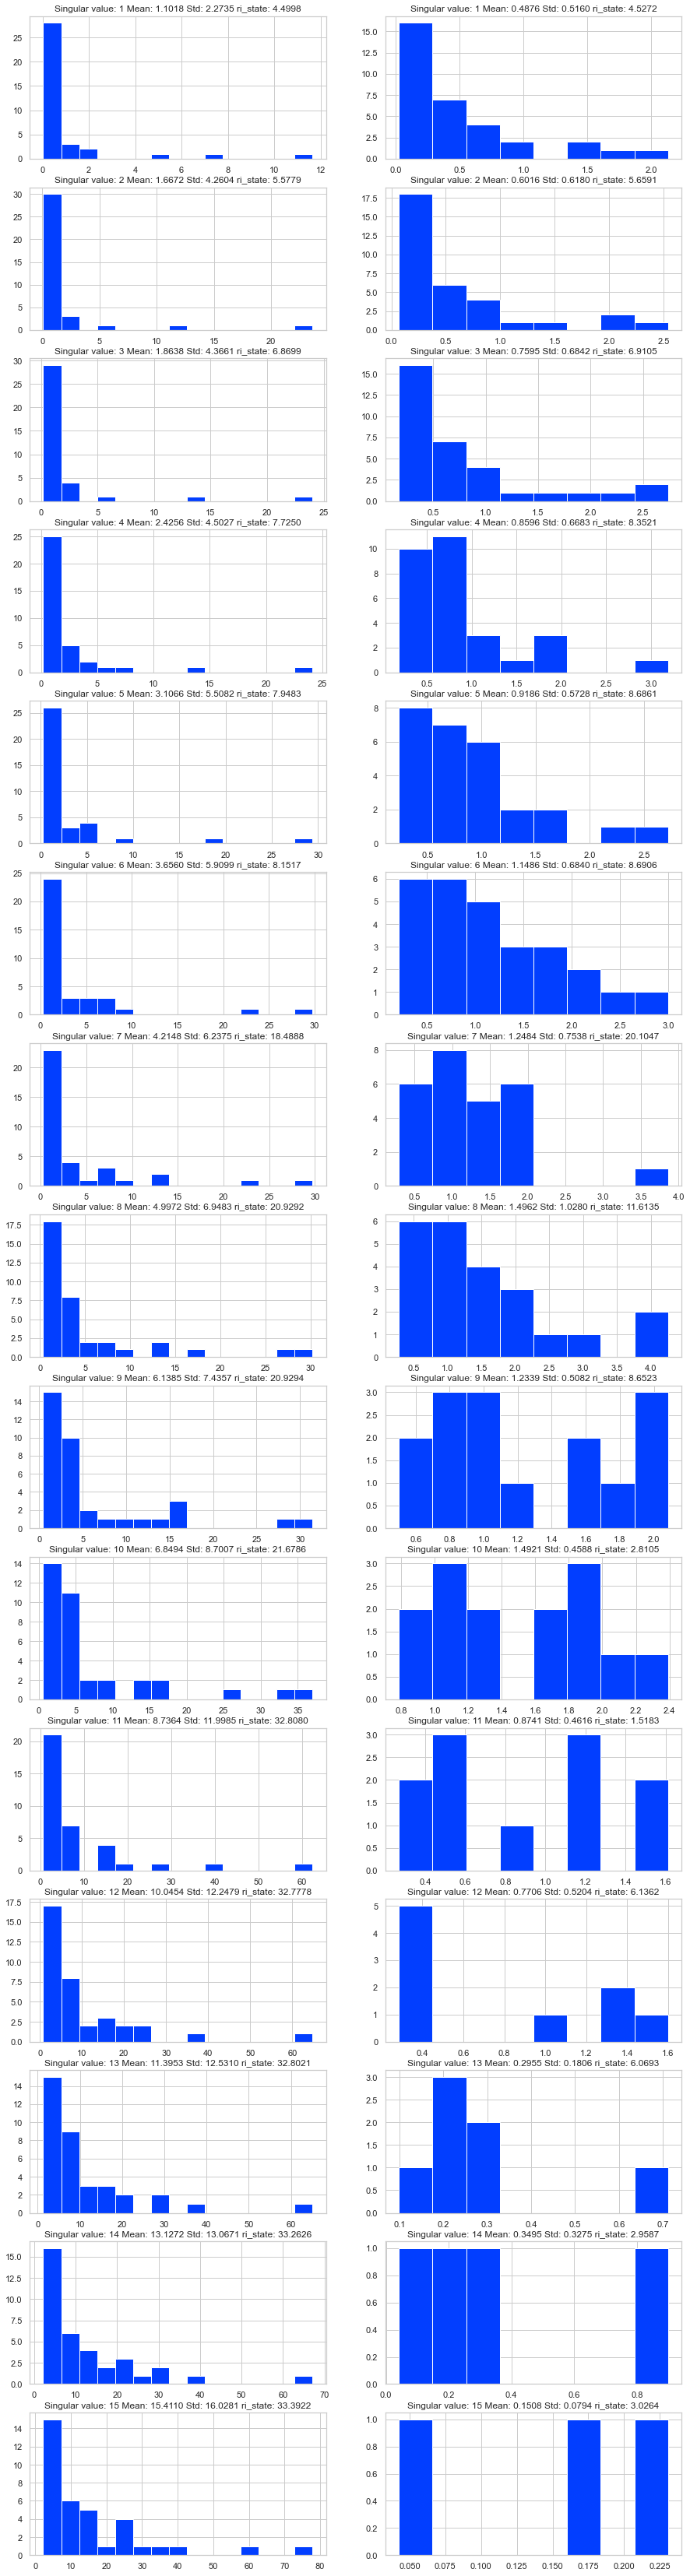

In [79]:
k = 15
fig, axes = plt.subplots(k, 2, figsize = (15, 60))
c = 3 #the cut off when generating new donor pool
p = 1
old = np.empty((k, 2))
new = np.empty((k, 2))

new_model_list = []    
stat_index = 3 #The index of the state we are plotting in the target list
print("Analysis for state %s"%(models[0][0][stat_index].state))

for i in range(k):
    perm_dict = models[i][0][stat_index].permutation_distribution(show_graph = False)
    old[i][1] = perm_dict.pop(models[i][0][stat_index].state)
    
     
    selected = np.array(list(perm_dict.values()))
    old[i][0] = np.mean(selected)
    axes[i][0].hist(selected, bins = 15)
    
    axes[i][0].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(selected), np.std(selected), models[i][0][stat_index].find_ri()))
    
    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    selected = selected[selected < c]

    new_model = syn_model(models[i][0][stat_index].state,  models[i][0][stat_index].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    new_model_list.append(new_model)
    new_perm_dict = new_model.permutation_distribution(show_graph = False)
    new[i][1] = new_perm_dict.pop(new_model.state)
    values = list(new_perm_dict.values())
    new[i][0] = np.mean(values)

    axes[i][1].hist(values, bins = 8)
    axes[i][1].set_title("Singular value: %s Mean: %2.4f Std: %2.4f ri_state: %2.4f"%(i+1, np.mean(values), np.std(values), new_model.find_ri()))

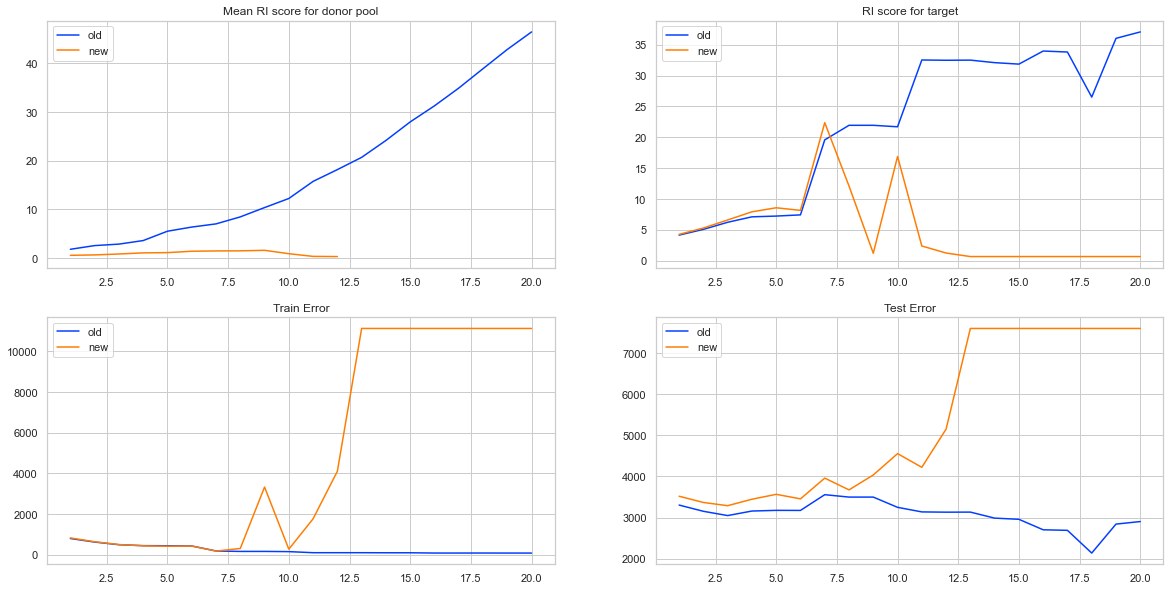

In [220]:
fig, axes = plt.subplots(2, 2, figsize = (20, 10))
axes[0][0].plot(range(1, len(old.T[0]) + 1), old.T[0], label = 'old')
axes[0][0].plot(range(1, len(new.T[0]) + 1), new.T[0], label = 'new')
axes[0][0].set_title('Mean error ratio for donor pool')
axes[0][0].legend()

axes[0][1].plot(range(1, len(old.T[1]) + 1), old.T[1], label = 'old')
axes[0][1].plot(range(1, len(new.T[1]) + 1), new.T[1], label = 'new')
axes[0][1].set_title('Mean error ratio for target')
axes[0][1].legend()

old_train_error = [m[0][stat_index].train_err for m in models[:k]]
old_test_error = [m[0][stat_index].test_err for m in models[:k]]

new_train_error = [new_model_list[i].train_err for i in range(k)]
new_test_error = [new_model_list[i].test_err for i in range(k)]

axes[1][0].plot(range(1, len(old.T[0]) + 1), old_train_error, label = 'old')
axes[1][0].plot(range(1, len(new.T[0]) + 1), new_train_error, label = 'new')
axes[1][0].set_title('Train Error')
axes[1][0].legend()


axes[1][1].plot(range(1, len(old.T[1]) + 1), old_test_error, label = 'old')
axes[1][1].plot(range(1, len(new.T[1]) + 1), new_test_error, label = 'new')
axes[1][1].set_title('Test Error')
axes[1][1].legend()


plt.show()

## Singular value threshold in training (difference between denoisedDF and actual)

In [258]:
num_states = len(models[0][0])
for stat_index in range(num_states):
    
    print((models[0][0][stat_index].state))
    X = models[0][0][stat_index].train
    a = np.max(X, axis = 0)
    b = np.min(X, axis = 0)
    X = (X - (a + b)/2)/((b-a)/2)
    mean = np.mean(X, axis = 1)
    p = 1
    sigma = np.sum(np.square(X[models[0][0][stat_index].state] - mean))/(len(X)-1)
    #sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
    s = np.linalg.svd(X)[1]
    l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
    h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

    l = len(s[s > l])
    h = len(s[s > h])
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 
                                                                  # https://www.jmlr.org/papers/volume19/17-777/17-777.pdf
    
    print((models[0][1][stat_index].state))
    X = models[0][1][stat_index].train
    a = np.max(X, axis = 0)
    b = np.min(X, axis = 0)
    X = (X - (a + b)/2)/((b-a)/2)
    mean = np.mean(X, axis = 1)
    p = 1
    sigma = np.sum(np.square(X[models[0][1][stat_index].state] - mean))/(len(X)-1)
    #sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
    s = np.linalg.svd(X)[1]
    l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
    h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

    l = len(s[s > l])
    h = len(s[s > h])
    print("theory singular value in range %2.1f to %2.1f"%(l, h)) #This is based on the equation (20) in the paper: 
                                                                  # https://www.jmlr.org/papers/volume19/17-777/17-777.pdf


Los Angeles-California
theory singular value in range 3.0 to 2.0
Niagara-New York
theory singular value in range 4.0 to 2.0
Broward-Florida
theory singular value in range 3.0 to 2.0
Cumberland-Maine
theory singular value in range 4.0 to 2.0
DeKalb-Georgia
theory singular value in range 5.0 to 4.0
Madison-New York
theory singular value in range 4.0 to 2.0
Bartholomew-Indiana
theory singular value in range 4.0 to 3.0
Albany-New York
theory singular value in range 7.0 to 5.0
Jefferson-Louisiana
theory singular value in range 2.0 to 1.0
Providence-Rhode Island
theory singular value in range 3.0 to 2.0


Model fit vs denoiseDF for Niagara-New York
normal_noise_sv: {'Niagara-New York': [2, 4, 5, 6, 7, 8, 9], 'Los Angeles-California': [11], 'Cumberland-Maine': [6, 8], 'Broward-Florida': [12, 13, 14, 15], 'DeKalb-Georgia': [5, 10, 11, 14], 'Madison-New York': [11, 12], 'Bartholomew-Indiana': [2, 4, 6, 14], 'Albany-New York': [3, 8, 9, 10, 11, 13, 14, 15], 'Jefferson-Louisiana': [2, 3, 13, 15], 'Providence-Rhode Island': [6, 7, 8, 13, 14]}


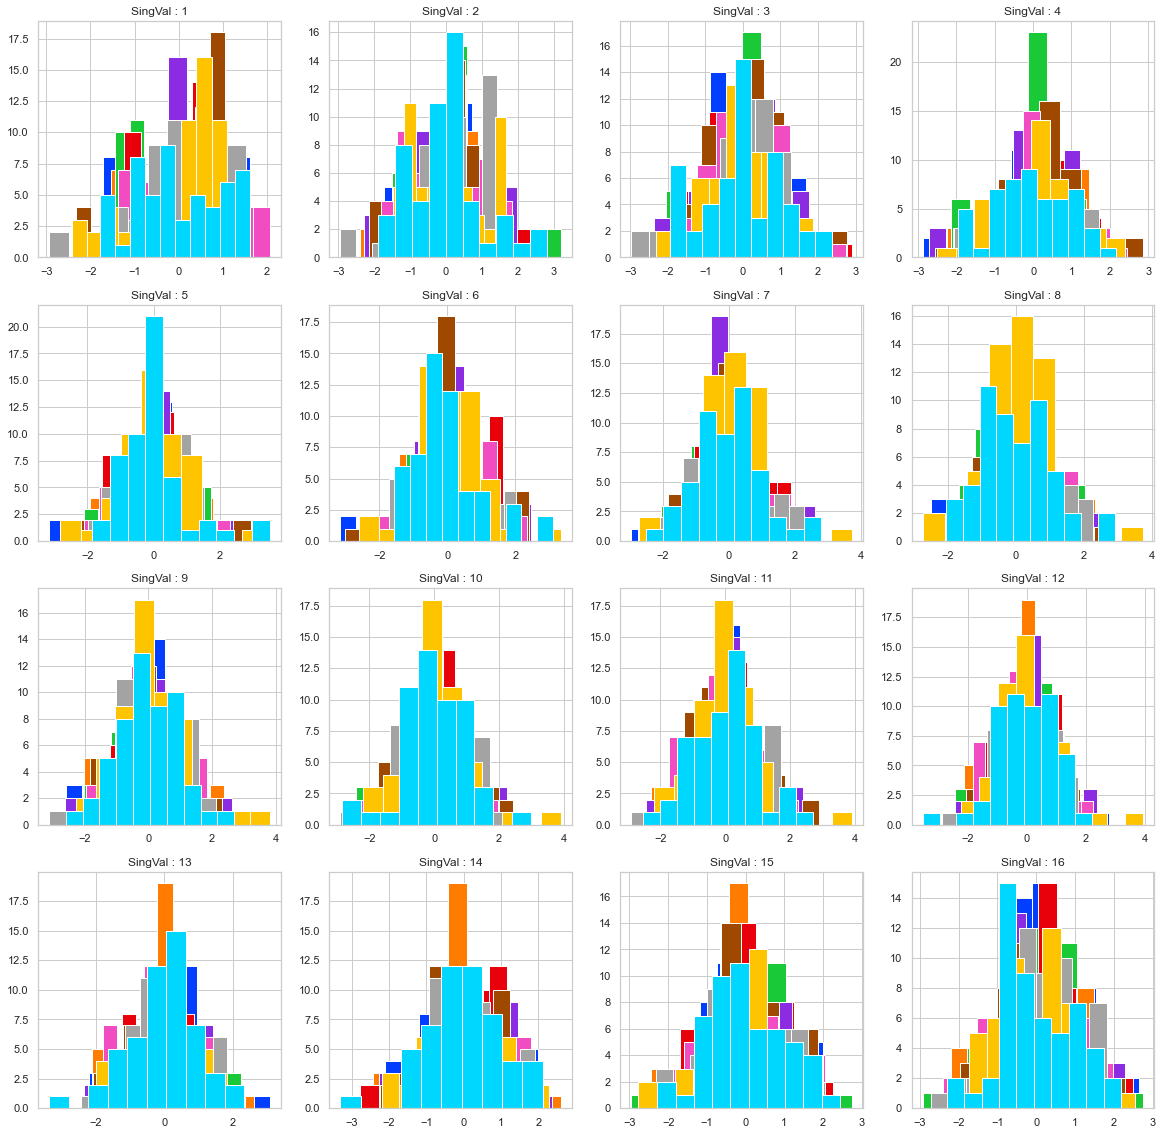

In [202]:
'''
The D statistic is the absolute max distance (supremum) between the CDFs of the two samples.
The closer this number is to 0 the more likely it is that the two samples were drawn from 
the same distribution. Check out the Wikipedia page for the k-s test. It provides a good 
explanation: https://en.m.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

The p-value returned by the k-s test has the same interpretation as other p-values. 
You reject the null hypothesis that the two samples were drawn from the same distribution 
if the p-value is less than your significance level. The online tables for the 
conversion of the D statistic into a p-value can be found.
'''

fig, axes = plt.subplots(4, 4, figsize = (20, 20))
state_idx = 0
donor = True #set False for the target states
donor_idx = 0
p = 0.95
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))


normal_noise_sv = {}
p_thresh = 0.95

for state_idx in range(5):
    #normal_noise_sv[m.state] = []

    for i in range(16):
        donor_idx = 0
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        axes[i//4][i%4].hist(error)
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        (D_statistic,p_value) = kstest(error,'norm')
        #print(p_value)
        if p_value > p_thresh:
            if m.state not in normal_noise_sv:
                normal_noise_sv[m.state] = []
            normal_noise_sv[m.state].append(i)
         
        donor_idx = 1
        m = models[i][donor_idx][state_idx]
        error = (m.denoisedDF[m.state].values - m.train[m.state].values)
        error = (error - error.mean()) / error.std()
        axes[i//4][i%4].hist(error)
        #axes[i//4][i%4].plot(m.denoisedDF[m.state].values - m.train[m.state].values)
        axes[i//4][i%4].set_title('SingVal : %s'%(i+1))
        (D_statistic,p_value) = kstest(error,'norm')
        #print(p_value)
        if p_value > p_thresh:
            if m.state not in normal_noise_sv:
                normal_noise_sv[m.state] = []
            normal_noise_sv[m.state].append(i)
        
print('normal_noise_sv:', normal_noise_sv)

In [203]:
pop_scaled = create_population_adjusted_data(uscounties_cases, uscounties_population)
#cluster_2_states = ['New York', 'New Jersey', 'Connecticut', 'Massachusetts'] # ['District of Columbia', 'Massachusetts', 'Michigan','New Jersey', 'New York', 'Vermont'] #I exclude Hawaii
cluster_2_states = ['Connecticut',
 'Maine',
 'Massachusetts',
 'New Hampshire',
 'Rhode Island',
 'Vermont',
 'New Jersey',
 'New York'
]
donors = []
for counties in uscounties_cases.columns:
    names = counties.split('-')
    if names[-1] in cluster_2_states and names[0] != 'Unknown':
        donors.append(counties)

        
targets = ['Los Angeles-California', 'Broward-Florida' ,'DeKalb-Georgia','Bartholomew-Indiana','Jefferson-Louisiana']#, 'Fulton-Georgia','Gwinnett-Georgia', 'Tarrant-Texas', 'Bexar-Texas','Collin-Texas','Mohave-Arizona','Yuma-Arizona','Maricopa-Arizona', 'Ascension-Louisiana',  'East Carroll-Louisiana']#counties_recommended# ['Ascension-Louisiana', 'Jefferson-Louisiana', 'Bartholomew-Indiana', 'Riverside-California', 'Broward-Florida' ]# #counties_recommended #masks_mandated


Los Angeles-California singVals is 11
Niagara-New York singVals is 2


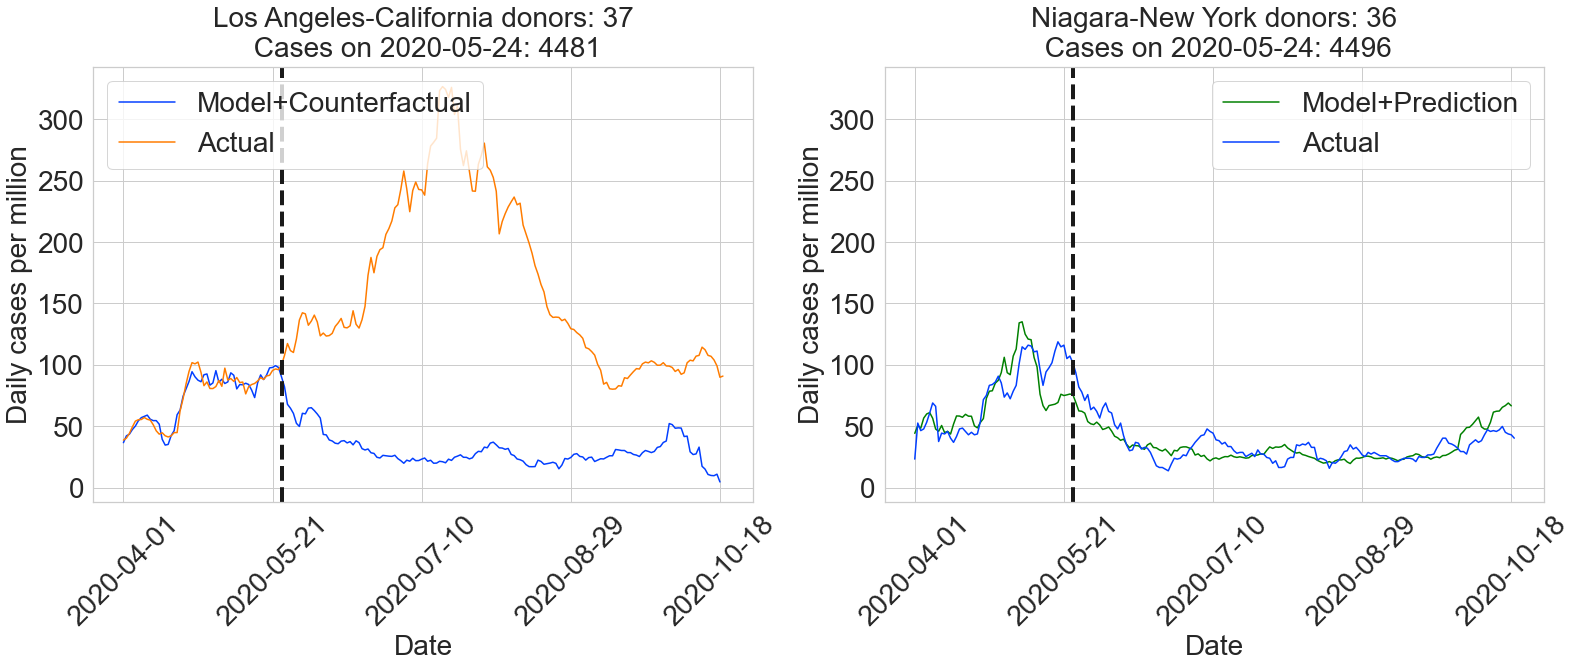

Broward-Florida singVals is 12
Cumberland-Maine singVals is 6


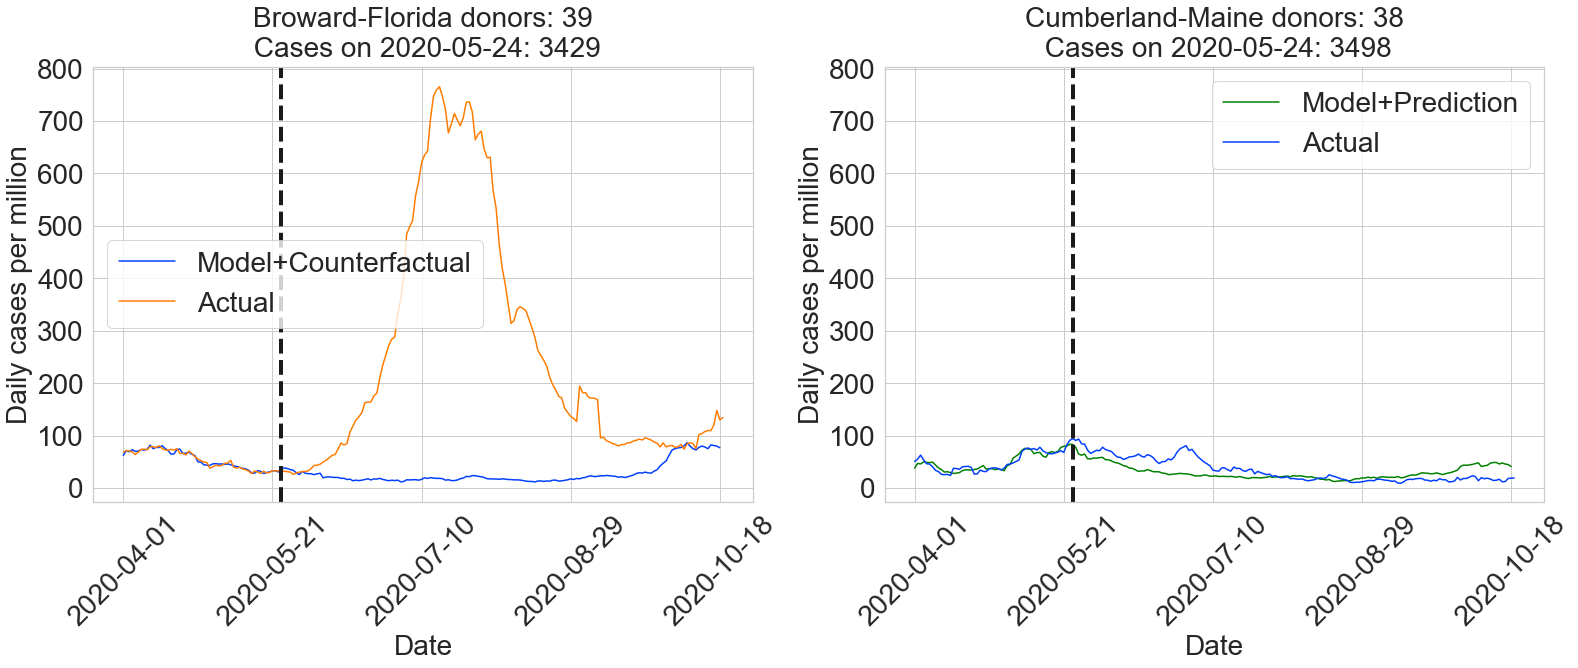

DeKalb-Georgia singVals is 5
Madison-New York singVals is 11


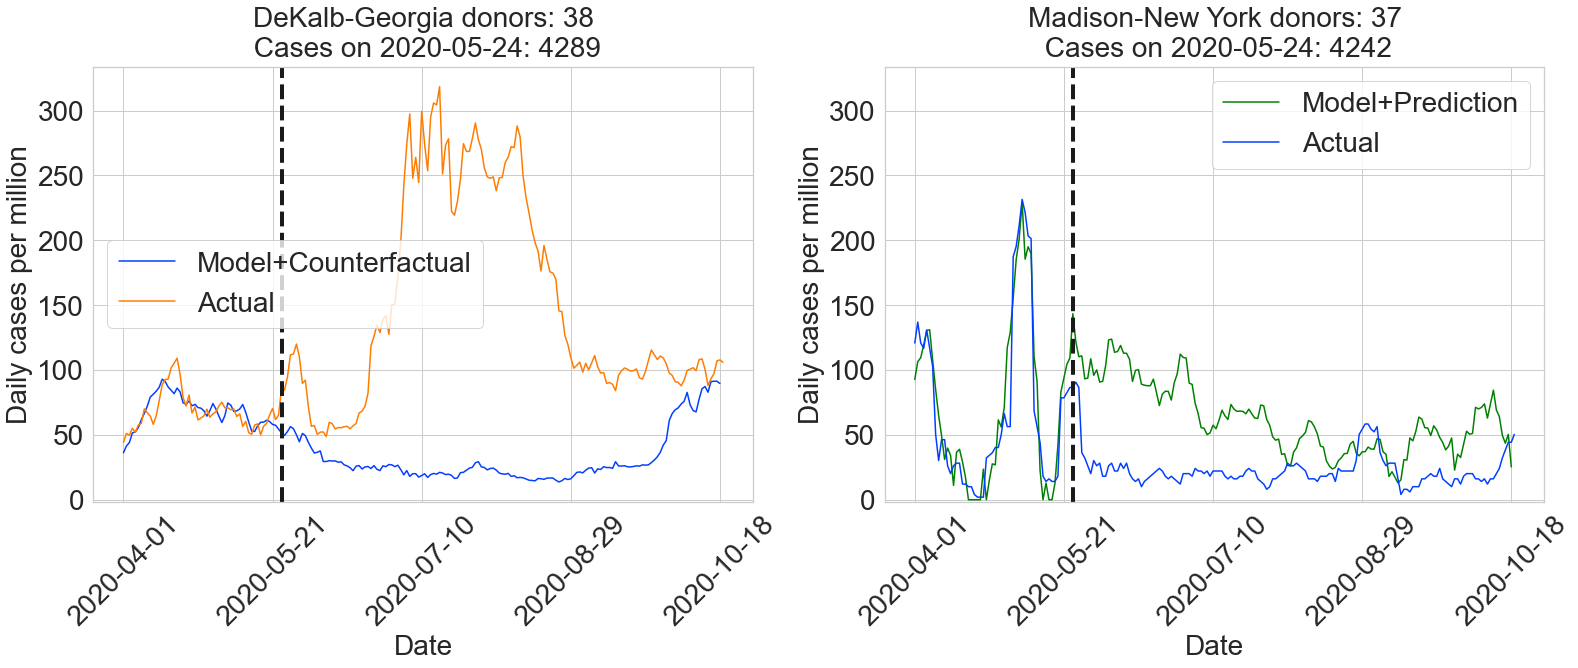

Bartholomew-Indiana singVals is 2
Albany-New York singVals is 3


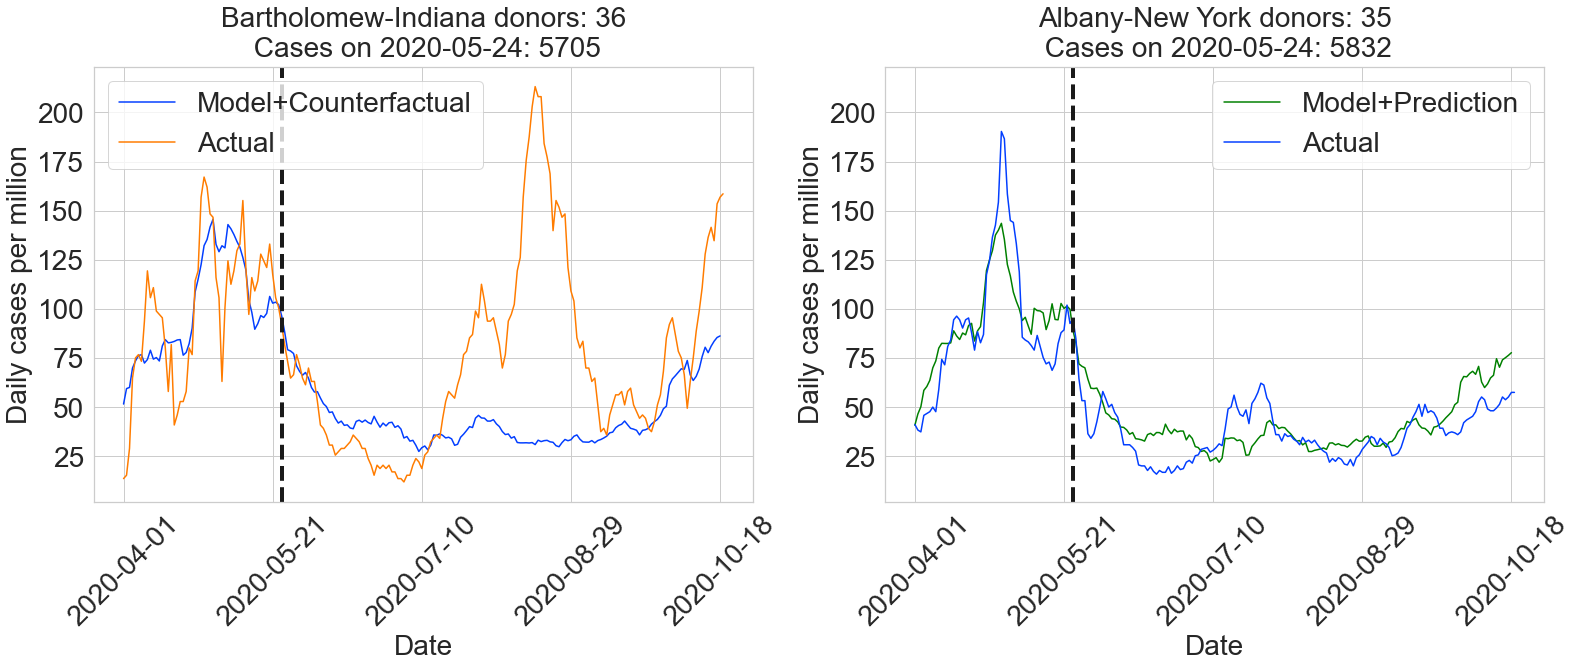

Jefferson-Louisiana singVals is 2
Providence-Rhode Island singVals is 6


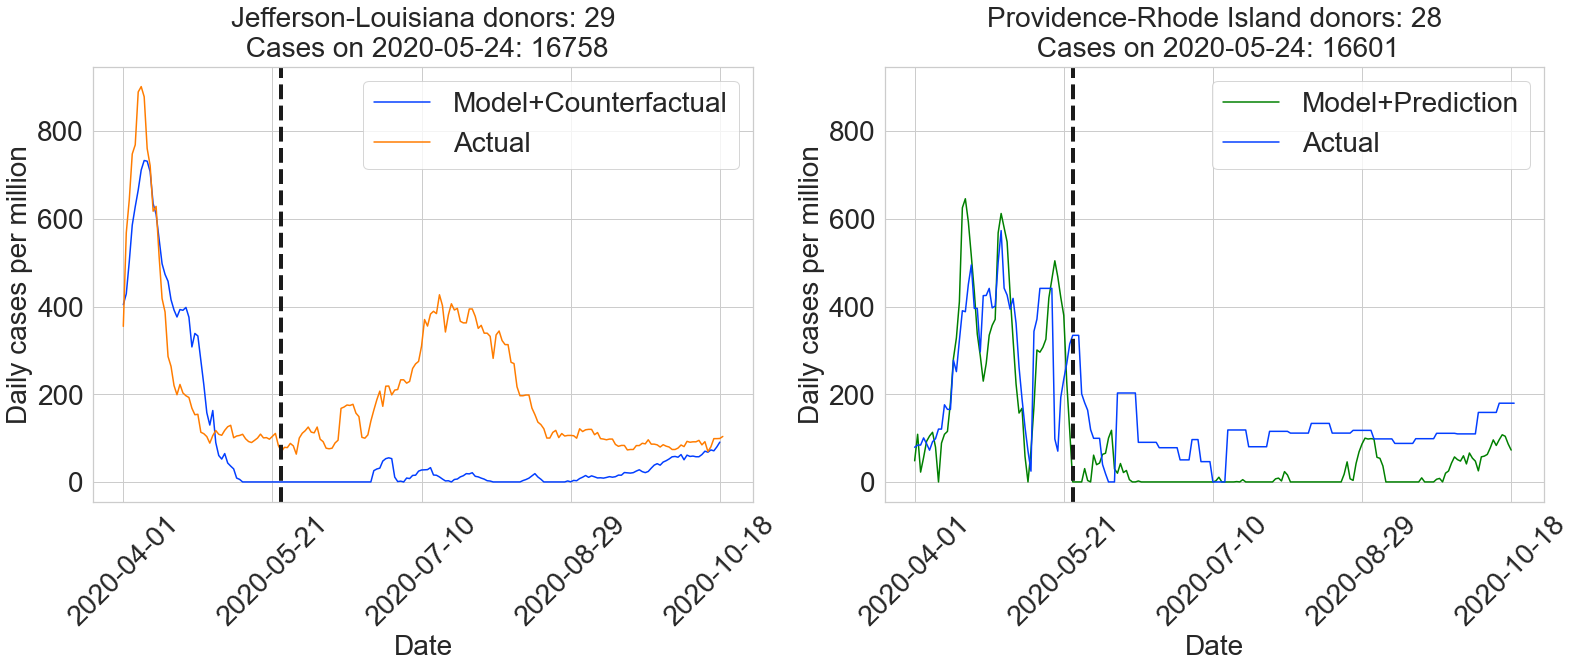

In [204]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=50
FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
singVals=4
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

i=1
for state in targets:
#otherStates = donors.copy()
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                       > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    '''
    otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
    '''
    if state in otherStates:
        otherStates.remove(state)
        
    '''
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit(trainDF)
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    print(model_fit, predictions)
       
        
    '''
    
    singVals = normal_noise_sv[state][0]
    print(state, 'singVals is', singVals)
    
    rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0
    
    #print(model_fit)
    #continue
        
    
    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[state][low_thresh+1:])
    #print(state, fit_error, prediction_error)
    if(len(otherStates)<5):
        print(otherStates)
        continue
    #     if(fit_error > 20):
    #         print(state, fit_error)
    #         continue
    if((trainDF[state]>10).any()):
        #print(state)
        w=2
    else:
        print(state)
        continue
        


    #ax = plt.subplot(num_rows_to_plot,2,2*i-1)
    ax = plt.subplot(1,2,1)
    #fig, ax = plt.subplots(1,1)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)
    plt.plot(np.concatenate((model_fit, predictions)), label='Model+Counterfactual'), plt.plot(df[state], label='Actual'), 
    plt.ylabel('Daily cases per million',fontsize=FONTSIZE),
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize=FONTSIZE)
    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    y_min, y_max = ax.get_ylim()


    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]
    #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
    #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
    #otherStates = list(otherStates[otherStates.isin(donors)])
    #print(state, "\n", len(otherStates))
    if new_state in otherStates:
        otherStates.remove(new_state)
    
    singVals = normal_noise_sv[new_state][0]
    print(new_state, 'singVals is', singVals)
    
    rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
    rscModel.fit(trainDF)
    denoisedDF = rscModel.model.denoisedDF()
    predictions = []

    predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
    predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
    model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
    predictions[predictions < 0 ] = 0 
    model_fit[model_fit < 0] = 0

    fit_error = mse(model_fit, df[state][:low_thresh])
    prediction_error = mse(predictions, df[new_state][low_thresh+1:])
                                                                                                         
    diversion = find_testing_diversion(df[new_state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][state]

    #ax = plt.subplot(num_rows_to_plot,2,2*i)
    ax = plt.subplot(1,2,2)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_title(new_state+" donors: "+str(len(otherStates))
                 + "\n Cases on "+ df_pop.index[low_thresh]+ ": " + str(int(df_pop[new_state].iloc[low_thresh])) ,fontsize=FONTSIZE, pad=10)

    plt.plot(np.concatenate((model_fit, predictions)), color='green', label='Model+Prediction'),
    plt.plot(df[new_state], label='Actual'), plt.legend(fontsize = FONTSIZE), 
    plt.ylabel('Daily cases per million',fontsize = FONTSIZE),
    plt.ylim([y_min, y_max])
    plt.axvline(x=df.index[low_thresh], color='k', linestyle='--', linewidth=4), plt.legend(fontsize = FONTSIZE)
    #plt.savefig("../figures/"+state+".png")

    plt.xlabel('Date',fontsize = FONTSIZE )
    plt.xticks(rotation=45, fontsize = FONTSIZE), plt.yticks(fontsize = FONTSIZE) 

    i=i+1
                                                                                                         
                                                                                                     

    plt.savefig('../Figures/COVID/'+state+'_'+new_state+'.pdf', bbox_inches='tight')

    plt.show()


In [205]:
#df = df[df.columns[(df>100).any()]].copy()
start_date = '2020-04-01'
low_thresh_date = '2020-05-24'
df = all_cases_data_pop_daily.loc[start_date:]
df_pop = all_cases_data_pop.loc[start_date:]
high_thresh = df_pop.shape[0]
low_thresh = (pd.to_datetime(low_thresh_date) - pd.to_datetime(start_date)).days

plt.rcParams.update({'font.size': 30})
tick_spacing=50
FONTSIZE = 28
#sizes = df.applynortheastries.last_valid_index)
#sizes = sizes.fillna(0).astype(int)
trainDF=df.iloc[:low_thresh,:]
testDF=df.iloc[low_thresh+1:high_thresh,:]

num_rows_to_plot = int(len(targets))+1
#plt.rcParams['figure.figsize'] = (24, num_rows_to_plot*5.0)
plt.rcParams['figure.figsize'] = (26, 8.0)

county_errors = {}

i=1
for state in targets:
    try:
        otherStates = df_pop.columns[(df_pop.iloc[low_thresh] < 
                                      df_pop[state].iloc[low_thresh]+.5*df_pop[state].iloc[low_thresh])&(df_pop.iloc[low_thresh]
                                       > df_pop[state].iloc[low_thresh]-0.5*df_pop[state].iloc[low_thresh])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(donors)])

    '''
    otherStates = ['Middlesex-Connecticut', 'Essex-Massachusetts', 'Genesee-New York']
    '''
    if state in otherStates:
        otherStates.remove(state)
        
    '''
    rscModel =syn_model(state, singVals, [df], high_thresh, low_thresh, otherStates=otherStates)
    rscModel.fit(trainDF)
    
    predictions = rscModel.predictions
    model_fit = rscModel.model_fit
    print(model_fit, predictions)
       
        
    '''
    new_state = otherStates[np.argmin(np.abs(df_pop[otherStates].iloc[low_thresh]-df_pop[state].iloc[low_thresh]))]

    county_errors[state] = []
    county_errors[new_state] = []

    for singVals in range(1,17):
    
    
        rscModel = RobustSyntheticControl(state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)

        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        predictions[predictions < 0 ] = 0 
        model_fit[model_fit < 0] = 0

        #print(model_fit)
        #continue


        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[state][low_thresh+1:])
        #print(state, fit_error, prediction_error)
        if(len(otherStates)<5):
            print(otherStates)
            continue
        #     if(fit_error > 20):
        #         print(state, fit_error)
        #         continue
        if((trainDF[state]>10).any()):
            #print(state)
            w=2
        else:
            print(state)
            continue
        diversion = find_testing_diversion(df[new_state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][state]

        county_errors[state].append(diversion)
        

        #otherStates = df.columns[(df.iloc[low_thresh] < df[new_state].iloc[low_thresh]+
        #                          .5*df[new_state].iloc[low_thresh])&(df.iloc[low_thresh] > df[new_state].iloc[low_thresh]-0.5*df[new_state].iloc[low_thresh])]
        #otherStates = list(otherStates[otherStates.isin(donors)])
        #print(state, "\n", len(otherStates))
        if new_state in otherStates:
            otherStates.remove(new_state)


        rscModel = RobustSyntheticControl(new_state, singVals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()
        predictions = []

        predictions = np.dot(testDF[otherStates].values, rscModel.model.weights)
        predictions_noisy = np.dot(testDF[otherStates].values, rscModel.model.weights)
        model_fit = np.dot(trainDF[otherStates][:], rscModel.model.weights)
        predictions[predictions < 0 ] = 0 
        model_fit[model_fit < 0] = 0

        fit_error = mse(model_fit, df[state][:low_thresh])
        prediction_error = mse(predictions, df[new_state][low_thresh+1:])

        diversion = find_testing_diversion(df[new_state][low_thresh+1:], predictions)/pop_scaled.loc['2020-05-25'][new_state]
        county_errors[new_state].append(diversion)


In [206]:

for county in county_errors:
    print('\\\\\n', county,  end=' ')
    for err in county_errors[county]:
        print('&', round(err, 3),  end=' ')
    

\\
 Los Angeles-California & 0.034 & 0.031 & 0.032 & 0.022 & 0.019 & 0.018 & 0.02 & 0.026 & 0.029 & 0.031 & 0.034 & 0.033 & 0.028 & 0.04 & 0.04 & 0.049 \\
 Niagara-New York & 0.037 & 0.023 & 0.024 & 0.024 & 0.023 & 0.024 & 0.025 & 0.027 & 0.027 & 0.025 & 0.024 & 0.026 & 0.025 & 0.037 & 0.035 & 0.035 \\
 Broward-Florida & 0.213 & 0.288 & 0.264 & 0.238 & 0.269 & 0.271 & 0.271 & 0.271 & 0.263 & 0.245 & 0.32 & 0.335 & 0.366 & 0.373 & 0.394 & 0.398 \\
 Cumberland-Maine & 0.219 & 0.186 & 0.13 & 0.096 & 0.1 & 0.104 & 0.106 & 0.109 & 0.136 & 0.121 & 0.116 & 0.103 & 0.098 & 0.087 & 0.086 & 0.092 \\
 DeKalb-Georgia & 0.066 & 0.072 & 0.07 & 0.072 & 0.133 & 0.117 & 0.122 & 0.135 & 0.138 & 0.133 & 0.149 & 0.151 & 0.194 & 0.193 & 0.273 & 0.314 \\
 Madison-New York & 0.079 & 0.123 & 0.16 & 0.144 & 0.157 & 0.14 & 0.123 & 0.132 & 0.423 & 0.533 & 0.582 & 1.474 & 1.551 & 1.731 & 2.919 & 3.082 \\
 Bartholomew-Indiana & 0.027 & 0.043 & 0.053 & 0.054 & 0.059 & 0.053 & 0.091 & 0.092 & 0.093 & 0.105 & 0.097 &

Model fit vs denoiseDF for Providence-Rhode Island


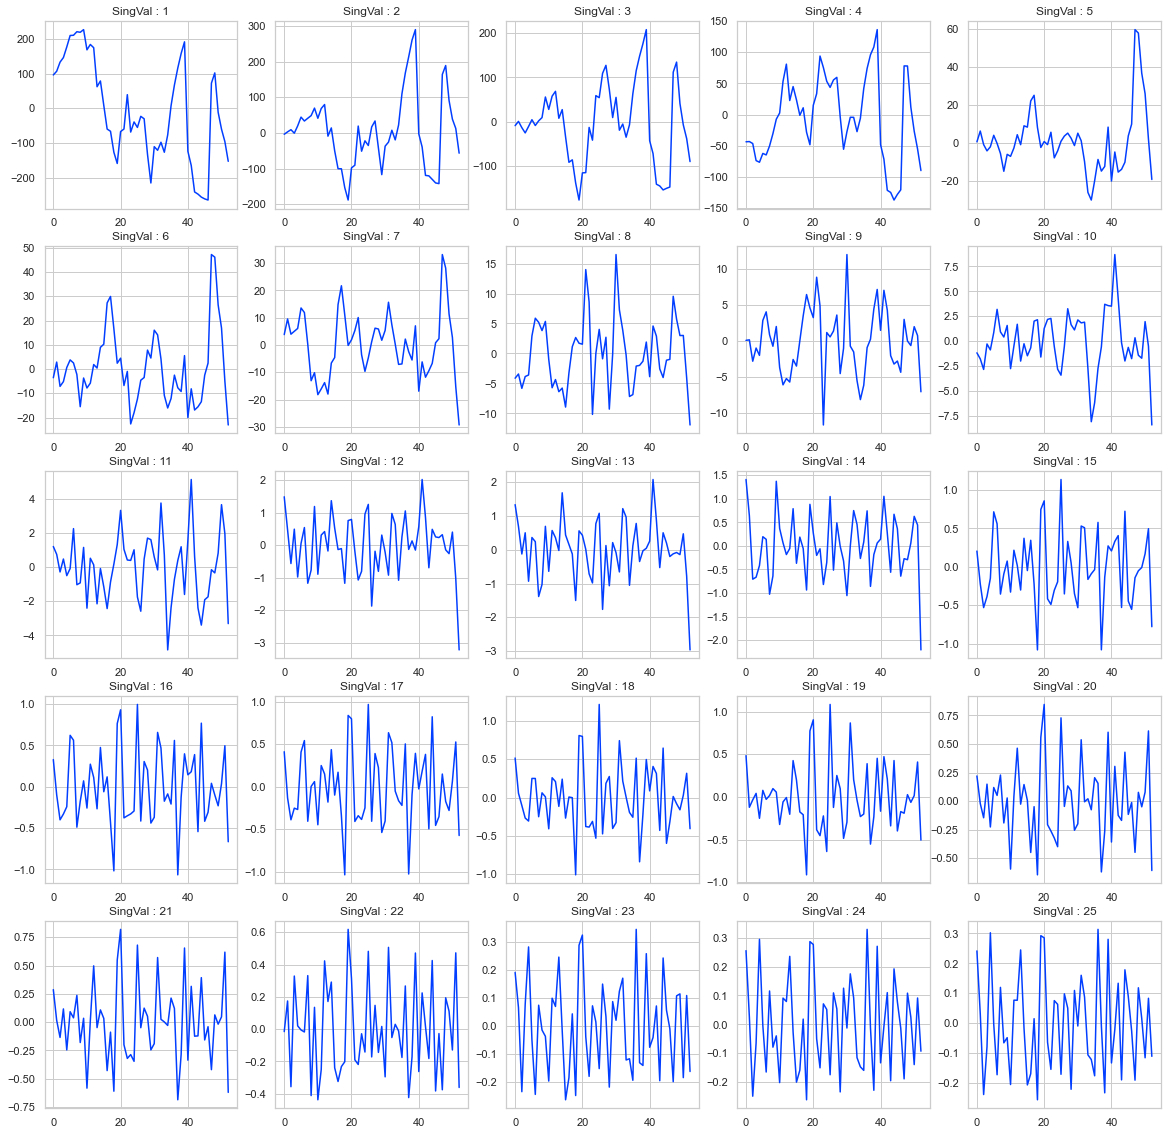

In [250]:
fig, axes = plt.subplots(5, 5, figsize = (20, 20))
state_idx = 4
donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))

error_mean = []
error_std = []

for i in range(25):
    
    
    m = models[i][donor_idx][state_idx]
    error_list = m.denoisedDF[m.state].values - m.train[m.state].values
    error_mean.append(np.mean(error_list))
    error_std.append(np.std(error_list))
                         
    axes[i//5][i%5].plot(error_list)
    axes[i//5][i%5].set_title('SingVal : %s'%(i+1))

## Singular value threshold in testing (difference between test and actual)

In [9]:
from sklearn.metrics import mean_squared_error

Prediction vs actual for Providence-Rhode Island


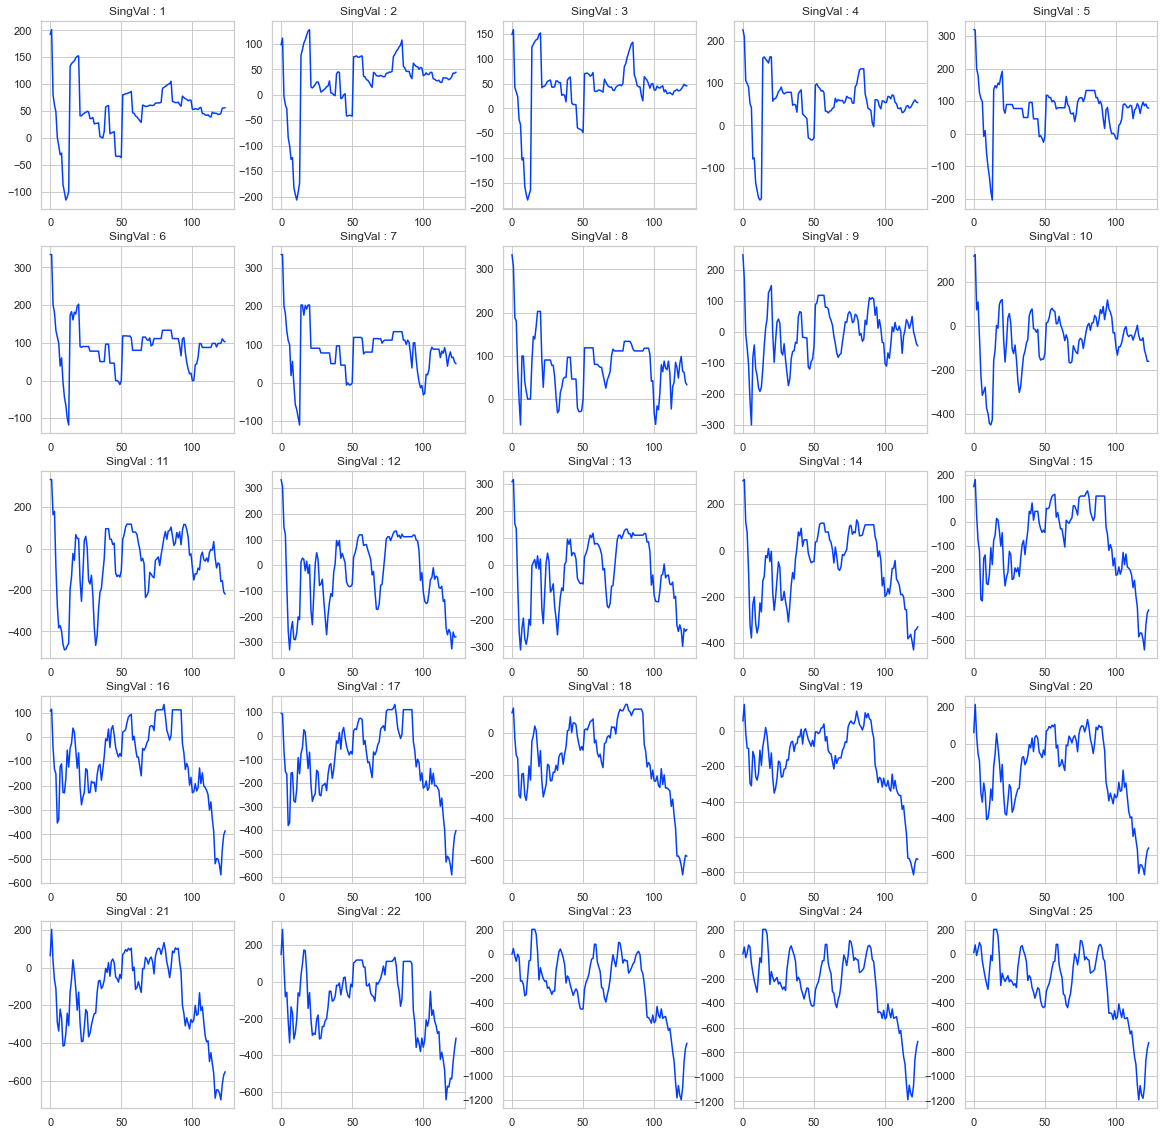

In [252]:
fig, axes = plt.subplots(5, 5, figsize = (20, 20))

donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1

mse_list = []
    
print('Prediction vs actual for %s'%(models[0][donor_idx][state_idx].state))

for i in range(25):
    m = models[i][donor_idx][state_idx]
    error_list = m.actual.values[low_thresh+1:] - m.predictions
    mse_list.append(mean_squared_error(m.actual.values[low_thresh+1:], m.predictions))
    axes[i//5][i%5].plot(error_list)
    axes[i//5][i%5].set_title('SingVal : %s'%(i+1))

In [253]:
# Using the mean for the rows using all the data
X = models[0][donor_idx][state_idx].train
a = np.max(X, axis = 0)
b = np.min(X, axis = 0)
X = (X - (a + b)/2)/((b-a)/2)
mean = np.mean(X, axis = 1)
p = 1
sigma = np.sum(np.square(X[models[0][donor_idx][state_idx].state] - mean))/(len(X)-1)
#sigma = np.var(X[models[0][donor_idx][state_idx].state], ddof = 1)
s = np.linalg.svd(X)[1]
l = (2.1)* np.sqrt(len(s) * (sigma * p + p * (1-p)))
h = (3)* np.sqrt(len(s) * (sigma * p + p * (1-p)))

l = len(s[s > l])
h = len(s[s > h])
l, h

(3, 2)

In [166]:
#X = models[0][donor_idx][state_idx].denoisedDF[models[0][donor_idx][state_idx].state]

# X = models[0][donor_idx][state_idx].actual.values #use the scaler value
# b = np.max(X)
# a = np.min(X)
# X = (X - (a + b)/2)/((b-a)/2)
# p = 1
# variance = np.var(X, ddof = 1)
# l = (2.1)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
# h = (3)* np.sqrt(high_thresh * (variance * p + p * (1-p)))
# s = np.linalg.svd(models[0][donor_idx][state_idx].train)[1]
# l = len(s[s > l])
# h = len(s[s > h])

Plots for Providence-Rhode Island


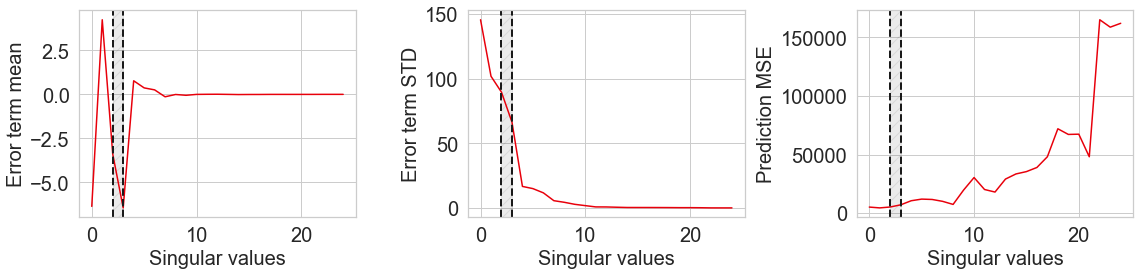

In [254]:

print('Plots for %s'%(models[0][donor_idx][state_idx].state))
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
FONTSIZE = 20

axes[0].plot(error_mean, color='r')
axes[0].set_ylabel('Error term mean', fontsize = FONTSIZE)
axes[0].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[0].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[0].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[0].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[1].plot(error_std, color='r')
axes[1].set_ylabel('Error term STD', fontsize = FONTSIZE)
axes[1].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[1].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[1].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[1].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[2].plot(mse_list, color='r')
axes[2].set_ylabel('Prediction MSE', fontsize = FONTSIZE)
axes[2].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[2].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[2].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[2].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[2].tick_params(axis='both', which='major', labelsize=FONTSIZE)

plt.tight_layout()

plt.savefig("../Figures/traintestrank-providence.pdf")

In [217]:
models[0][donor_idx][state_idx].train.to_csv("../../Desktop/research/rank_estimation (1)/test.csv")

### trend when filter out some donor pools units

In [247]:
state_idx = 4
c = 3
donor = True #set False for the target states
donor_idx = 0
if donor:
    donor_idx = 1
print('Model fit vs denoiseDF for %s'%(models[0][donor_idx][state_idx].state))

error_mean = []
error_std = []
mse_list = []
df = all_cases_data_pop_daily.loc[start_date:]
for i in range(25):
    
    perm_dict = models[i][donor_idx][state_idx].permutation_distribution(show_graph = False)
    perm_dict.pop(models[i][donor_idx][state_idx].state)
    selected = np.array(list(perm_dict.values()))
    
    #Select new donors
    new_donor = list(np.array(list(perm_dict.keys()))[selected < c])
    #print(new_donor, models[i][donor_idx][state_idx].state)

    new_model = syn_model(models[i][donor_idx][state_idx].state,  models[i][0][state_idx].kSingularValues, [df], high_thresh, low_thresh, otherStates=new_donor)
    new_model.fit_model()
    
    error_list = new_model.denoisedDF[m.state].values - new_model.train[m.state].values
    error_mean.append(np.mean(error_list))
    error_std.append(np.std(error_list))
    mse_list.append(new_model.test_err)

Model fit vs denoiseDF for Providence-Rhode Island


Plots for Providence-Rhode Island


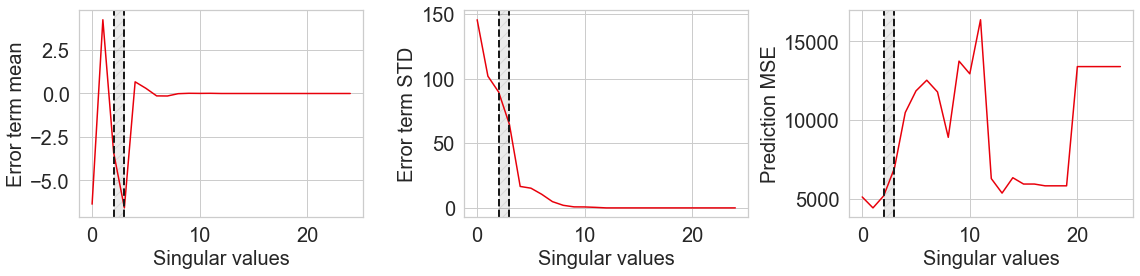

In [248]:

print('Plots for %s'%(models[0][donor_idx][state_idx].state))
fig, axes = plt.subplots(1, 3, figsize = (16, 4))
FONTSIZE = 20

axes[0].plot(error_mean, color='r')
axes[0].set_ylabel('Error term mean', fontsize = FONTSIZE)
axes[0].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[0].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[0].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[0].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[0].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[1].plot(error_std, color='r')
axes[1].set_ylabel('Error term STD', fontsize = FONTSIZE)
axes[1].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[1].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[1].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[1].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[1].tick_params(axis='both', which='major', labelsize=FONTSIZE)

axes[2].plot(mse_list, color='r')
axes[2].set_ylabel('Prediction MSE', fontsize = FONTSIZE)
axes[2].set_xlabel('Singular values', fontsize = FONTSIZE)
axes[2].axvline(x = l, color='k', linestyle='--', linewidth=2, label = "Lower Bound")
axes[2].axvline(x = h, color='k', linestyle='--', linewidth=2, label = "High Bound")
axes[2].axvspan(l, h, alpha=0.08, color = 'black',fill = 'false',hatch="//")
axes[2].tick_params(axis='both', which='major', labelsize=FONTSIZE)

plt.tight_layout()

plt.savefig("../Figures/traintestrank.pdf")

## Toy example

In [4]:
x = np.arange(1, 100, 1)
a = np.sin(x + 1) * 1
b = np.sin(x/2) * 3
c = np.sin(4*x + 3) * 0.25
d = np.sin(2*x-3) * 0.4

data = a + b + c + d


toy_df = {}
for i in range(50):
    err = 0.2*np.random.uniform(-1,1,size = 99)
    toy_df[i] = np.random.rand() * a + np.random.rand() * b + np.random.rand() * c + np.random.rand() * d + err

In [5]:
toy_df = pd.DataFrame(toy_df)

intervention = 30

In [6]:
toy_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.467614,0.432884,0.993822,1.528576,1.115679,1.089483,1.875033,2.068563,1.224993,1.977737,...,1.320728,1.054202,1.544797,0.813985,1.609863,2.102367,0.480648,0.361804,1.274739,2.007076
1,1.493854,0.735013,2.002709,0.975439,0.976813,0.653127,2.007590,2.404197,1.664992,2.737826,...,1.702849,0.900689,2.171205,0.807518,1.549465,2.270550,0.278515,0.880828,1.197202,2.401673
2,1.511905,0.629292,2.272379,0.539450,0.121463,-0.038456,1.630423,2.279284,1.688475,2.357076,...,1.834294,0.125948,1.268478,-0.417060,1.548864,1.919454,0.022189,0.813518,1.036081,2.385418
3,0.923924,0.396996,1.527419,0.204808,-0.208295,-0.261199,0.764117,1.746911,1.420983,1.344388,...,1.221979,-0.114121,0.676348,-0.727707,1.114938,1.323452,-0.001116,0.653999,1.002102,1.783601
4,0.924776,0.297831,1.427071,0.540595,0.307260,0.167807,0.968645,1.316831,0.988349,1.658130,...,1.028415,0.300764,1.340382,0.005401,0.848207,1.389157,-0.087374,0.660759,0.642062,1.564112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,-0.120025,-0.391782,-1.229073,0.446943,0.455161,0.273798,-0.239487,-0.313157,-0.578132,-0.461294,...,-0.503540,0.334524,-0.066783,0.365952,-0.076279,-0.244241,0.214910,-0.512921,-0.113021,-0.474615
95,-1.219204,-0.600307,-1.578377,-0.655590,-0.409330,-0.145499,-1.423892,-1.683394,-1.129437,-1.810002,...,-1.126313,-0.341913,-1.252488,0.047283,-1.281131,-1.774039,-0.209543,-0.528605,-0.960005,-2.147003
96,-2.025580,-0.601076,-1.892480,-1.466696,-1.268784,-0.846556,-2.556737,-3.133770,-1.847605,-2.970910,...,-1.892033,-1.405770,-2.223475,-0.638886,-1.898848,-2.972112,-0.286449,-0.903169,-1.720745,-3.119180
97,-2.440550,-1.282762,-2.906085,-2.204362,-2.025028,-1.457587,-3.690971,-3.771311,-2.138139,-4.025318,...,-2.977884,-1.800777,-3.260823,-1.557802,-2.490856,-3.616725,-0.641407,-0.994232,-2.048679,-3.308836


In [7]:
#scaler
np.sum(np.square((toy_df[0][:intervention] - toy_df.iloc[:intervention][0].mean())))/(intervention-1)

1.742911210130305

In [8]:
m = syn_model(0, 4, [toy_df], 200, intervention, otherStates=list(toy_df.columns)[1:])
m.fit_model(force_positive=False)

In [9]:
#vector
np.sum(np.square((toy_df[0][:intervention] - m.denoisedDF[0])))/(intervention-1)

0.010327391077546993

In [10]:
#by mean vector
X = m.train
mean = np.mean(X, axis = 1)
sigma = np.sum(np.square(X[0] - mean))/(intervention-1)
sigma

0.0441804600183345

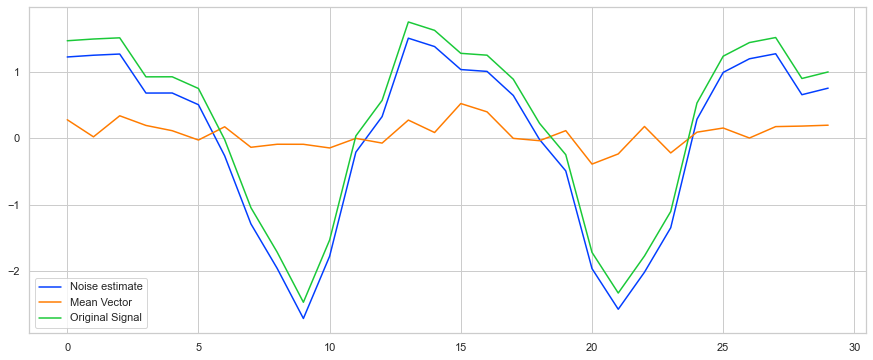

In [18]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(toy_df[0][:intervention] - toy_df.iloc[:intervention][0].mean(), label='Noise estimate')
plt.plot(X[0] - mean, label='Mean Vector')
plt.plot(toy_df[0][0:intervention], label='Original Signal')
plt.legend()
plt.savefig("../Figures/faultyestimate.pdf")
#plt.plot(toy_df[0][:intervention] - m.denoisedDF[0])

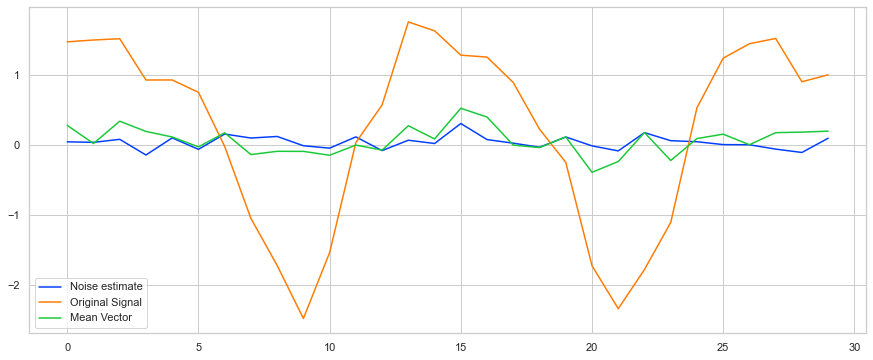

In [17]:
fig, axes = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(toy_df[0][:intervention] - m.denoisedDF[0], label='Noise estimate')
plt.plot(toy_df[0][0:intervention], label='Original Signal')
plt.plot(X[0] - mean, label='Mean Vector')
plt.legend()

plt.savefig("../Figures/correctestimate.pdf")
#plt.plot(toy_df[0][:intervention] - m.denoisedDF[0])

In [ ]:
m.plot(show_denoise = True)

In [ ]:
m.plot(show_denoise = True)

In [ ]:
m.svd_spectrum(show_plot = True)